Plotting a cross-section of PV from the GFS analysis
========================================

Use Xarray module to read in model data from nomads or unidata server.

Calculate theta and PV, calculate and plot cross-section

Adapted from: https://unidata.github.io/MetPy/latest/examples/cross_section.html

Import all of our needed modules

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib

import numpy as np
import scipy.ndimage as ndimage
import xarray as xr
import pandas as pd

from metpy.interpolate import cross_section
import metpy.calc as mpcalc
from metpy.calc import potential_vorticity_baroclinic
from metpy.units import units

Accessing data using Xarray
---------------------------

In [2]:
# Specify our date/time of product desired
dt = datetime(2025, 1, 21, 12)  ## year, month, day, hour, minute, second

########### for near-real-time data, use unidata thredds
#base_url = "https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg_ana/"
#data = xr.open_dataset(f'{base_url}GFS_Global_0p5deg_ana_{dt:%Y%m%d}_{dt:%H}00.grib2',
#                       decode_times=True)


#########for archived data, use NCEI below:
# Construct our OPeNDAP access URL
base_url = "https://www.ncei.noaa.gov/thredds/dodsC/model-gfs-g4-anl-files/"

data = xr.open_dataset(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/'
                       f'gfs_4_{dt:%Y%m%d}_{dt:%H}00_000.grb2',
                       decode_times=True)

##### or for even older archived data:
# Construct our OPeNDAP access URL
#base_url = "https://www.ncei.noaa.gov/thredds/dodsC/model-gfs-g4-anl-files-old/"

#data = xr.open_dataset(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/'
#                       f'gfsanl_4_{dt:%Y%m%d}_{dt:%H}00_000.grb2',
#                       decode_times=True)


If you want, you can print the metadata and the names of all the variables in your dataset:

In [3]:
data

<xarray.Dataset> Size: 724MB
Dimensions:                                                                   (
                                                                               lat: 361,
                                                                               lon: 720,
                                                                               time: 1,
                                                                               height_above_ground_layer: 1,
                                                                               height_above_ground_layer_bounds_1: 2,
                                                                               ...
                                                                               sigma_layer_bounds_1: 2,
                                                                               pressure_difference_layer2: 3,
                                                                               pressure_difference_layer2_bounds_1: 2,
                                                                               height_above_ground4: 7,
                                                                               height_above_ground5: 3,
                                                                               potential_vorticity_surface: 2)
Coordinates: (12/25)
  * lat                                                                       (lat) float32 1kB ...
  * lon                                                                       (lon) float32 3kB ...
    reftime                                                                   datetime64[ns] 8B ...
  * time                                                                      (time) datetime64[ns] 8B ...
  * height_above_ground_layer                                                 (height_above_ground_layer) float32 4B ...
  * height_above_ground                                                       (height_above_ground) float32 4B ...
    ...                                                                        ...
  * hybrid1                                                                   (hybrid1) float32 4B ...
  * sigma_layer                                                               (sigma_layer) float32 16B ...
  * pressure_difference_layer2                                                (pressure_difference_layer2) float32 12B ...
  * height_above_ground4                                                      (height_above_ground4) float32 28B ...
  * height_above_ground5                                                      (height_above_ground5) float32 12B ...
  * potential_vorticity_surface                                               (potential_vorticity_surface) float32 8B ...
Dimensions without coordinates: height_above_ground_layer_bounds_1,
                                depth_below_surface_layer_bounds_1,
                                pressure_difference_layer_bounds_1,
                                height_above_ground_layer1_bounds_1,
                                pressure_difference_layer1_bounds_1,
                                sigma_layer_bounds_1,
                                pressure_difference_layer2_bounds_1
Data variables: (12/133)
    LatLon_Projection                                                         int32 4B ...
    height_above_ground_layer_bounds                                          (height_above_ground_layer, height_above_ground_layer_bounds_1) float32 8B ...
    depth_below_surface_layer_bounds                                          (depth_below_surface_layer, depth_below_surface_layer_bounds_1) float32 32B ...
    pressure_difference_layer_bounds                                          (pressure_difference_layer, pressure_difference_layer_bounds_1) float32 8B ...
    height_above_ground_layer1_bounds                                         (height_above_ground_layer1, height_above_ground_layer1_bounds_1) float32 8B ...
    pressure_d

Put valid time into pandas datetime

In [4]:
#vtime = pd.to_datetime(data.time)[0]
vtime = pd.to_datetime(dt)
vtime

Timestamp('2025-01-21 12:00:00')

Subset the dataset down to what we need, parse with metpy and squeeze

In [26]:
### subset dataset down to what we need
## for PV, need theta, pressure, u, v
data_subset = data.metpy.parse_cf([
    'u-component_of_wind_isobaric',
    'v-component_of_wind_isobaric',
    'Temperature_isobaric',
    'Geopotential_height_isobaric',
    'Relative_humidity_isobaric',
    'Geopotential_height_surface'
]).sel(time=vtime).squeeze().rename({'isobaric1':'isobaric'})

## subset to CONUS area
data_subset = data_subset.sel(lon=slice(230,300), lat=slice(60,20))


Calculate theta and PV

In [28]:
data_subset['Potential_temperature'] = mpcalc.potential_temperature(
    data_subset['Temperature_isobaric'].metpy.vertical,
    data_subset['Temperature_isobaric'])

## if we have the 'isobaric3' variables in the files, also run this
data_subset['Potential_temperature'] = data_subset['Potential_temperature'].metpy.sel(vertical=slice(100,100000)) #.rename({'isobaric1':'isobaric'})

data_subset['Potential_vorticity'] = mpcalc.potential_vorticity_baroclinic(
    data_subset['Potential_temperature'], data_subset['Potential_temperature'].metpy.vertical, 
    data_subset['u-component_of_wind_isobaric'], data_subset['v-component_of_wind_isobaric'])

# Compute ground elevation in pressure from standard atmsophere and the elevation
# of each station
data_subset['elevation'] = mpcalc.height_to_pressure_std(data_subset['Geopotential_height_surface']*units.meters)
                                                         #* units('meters'))
    
### and 850-mb vorticity
uwnd_850 = data_subset['u-component_of_wind_isobaric'].metpy.sel(vertical=850*units.hPa)
vwnd_850 = data_subset['v-component_of_wind_isobaric'].metpy.sel(vertical=850*units.hPa)

relvor_850 = mpcalc.smooth_n_point(mpcalc.vorticity(uwnd_850, vwnd_850),9)


Also do a separate subset for data on the DT

In [29]:
dt_subset = data.metpy.parse_cf([
    'Temperature_potential_vorticity_surface',
    'Pressure_potential_vorticity_surface',
    'u-component_of_wind_potential_vorticity_surface',
    'v-component_of_wind_potential_vorticity_surface',
]).sel(time=vtime).squeeze()

## subset to CONUS area
dt_subset = dt_subset.sel(lon=slice(230,300), lat=slice(60,20), potential_vorticity_surface=2.e-6)


Calculate theta

In [30]:
dt_subset['Potential_temperature'] = mpcalc.potential_temperature(
    dt_subset['Pressure_potential_vorticity_surface'],
    dt_subset['Temperature_potential_vorticity_surface']
)

dt_theta = ndimage.gaussian_filter(dt_subset['Potential_temperature'], sigma=1, order=0) * units('kelvin')

Define start and end points for cross section

In [64]:
start = (37., -116.)
end = (37., -68)

Get the cross section, and convert lat/lon to supplementary coordinates

In [65]:
cross = cross_section(data_subset, start, end).set_coords(('lat', 'lon'))
cross

Magnitude,[[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [279.3482971191406 278.9768664860453 276.8561947958379 ... 276.70934044382443 277.42653689401516 278.1407165527344] [278.6619873046875 278.2857835827047 276.170124442709 ... 276.62291240810055 277.3808469716897 278.1281433105469] [277.9920959472656 277.6111709842149 275.5087783314041 ... 276.6372747461413 277.4006525913778 278.152099609375]]
Units,kelvin
Magnitude,[[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [1.2035648055114342e-07 2.3682056480932426e-07 2.4630170214594093e-07 ... 2.0252896879445897e-08 -7.423232352402662e-09 1.4802223653148235e-09] [1.1567032485220619e-07 2.3238399017390093e-07 2.3850624956116264e-07 ... -4.166882064987401e-09 -2.607019645843798e-08 -6.865990239356021e-09] [1.1230345771254643e-07 2.2718500737985664e-07 2.3152172748260286e-07 ... -2.0361667400097628e-08 -3.6516993094835784e-08 -1.4149583200625453e-08]]
Units,kelvin meter2/(kilogram second)
Magnitude,[862.0092163085938 855.6781904223736 866.0027589425504 852.9270993219027 839.9741515258038 805.8830057507089 777.0317171830457 767.951867623375 769.4083334989052 760.2348688512426 768.7835906206931 819.1162975356359 835.5473182149799 815.6091321739761 800.0462990861434 782.102457330104 759.9087718883385 781.3618424989675 733.6079791655452 737.6373519707682 696.7444163724147 719.5637118424224 742.8183945744099 763.346371487582 797.222011632133 813.8141608665483 835.53972614482 846.4546727255845 858.0196352285969 874.4455108845664 890.9679339343796 902.1719557382937 912.3686223800032 923.0087193378922 934.0494548327713 944.5053836012821 953.332496684799 959.0475921504135 962.3538503573618 965.117104585597 966.0200098765918 967.6318229809166 972.5959214250945 977.451805474172 978.9265391851746 979.6373952191561 982.7462683443425 986.2009689409235 985.7511010111814 985.3897712457292 987.4196842958492 989.9856448780549 992.218912334262 991.3282960576955 990.3191361643011 990.5165171544555 989.6728860147452 989.1450954374649 990.8972122544843 991.3060135240373 987.9067455200649 986.538646868898 984.5626763351065 981.0085687242305 982.949513954589 983.4237230893212 979.849232888427 981.0926812830774 984.3366274692864 984.1693261589328 984.9069091679942 980.7219854082905 975.1960353310727 959.0900525013968 926.4866536774849 913.746900452172 954.1476477013304 962.2203828405703 994.1962272399846 1002.7225244872197 1008.4464068571498 1010.9646527604027 1012.7076778028315 1011.8179533653573 1013.0155194066872 1013.2399432263535 1013.2429809570311 1013.2429809570311 1013.2429809570312 1013.2429809570312 1013.2429809570312 1013.2429809570312 1013.2429809570312 1013.2429809570312 1013.2429809570311 1013.2429809570312 1013.2429809570311 1013.2429809570312 1013.2429809570312 1013.2429809570312]
Units,hectopascal


Calculate wind components

In [66]:
cross['wind_speed'] = mpcalc.wind_speed(cross['u-component_of_wind_isobaric'],cross['v-component_of_wind_isobaric'])

cross['u-component_of_wind_isobaric'] = cross['u-component_of_wind_isobaric'].metpy.convert_units('knots')
cross['v-component_of_wind_isobaric'] = cross['v-component_of_wind_isobaric'].metpy.convert_units('knots')
cross['t_wind'], cross['n_wind'] = mpcalc.cross_section_components(
    cross['u-component_of_wind_isobaric'],
    cross['v-component_of_wind_isobaric']
)

## get pressure levels into hPa instead of Pa
cross['isobaric'] = cross['isobaric']/100. 

cross

Magnitude,[[159.76474671332934 155.18646125837094 154.330219040335 ... 214.41647321839108 217.72339708063834 217.691318520202] [164.01204218359797 157.67120005129453 156.00752578681866 ... 206.99089905937296 211.9638436507753 212.99693229131515] [128.68040838715325 126.80422488307002 125.95976530340108 ... 213.4714078017952 217.3921264541081 218.29165135295037] ... [-1.8745903191247204 1.3939741141759971 2.3269637776438308 ... 4.482699751512064 2.9542159390778395 3.74312035208387] [-1.8891406368230899 1.397729971198441 2.32167206280693 ... 4.591640972920883 2.7552366953882124 3.6702546393639586] [-1.8818132820706133 1.4015160187995972 2.321433791953678 ... 4.7182799034694005 2.6032933860657317 3.619266714957054]]
Units,knot
Magnitude,[[-51.37966271353077 -48.62405180779938 -46.477048978348265 ... 23.185694483994027 26.386873819387553 29.48426705972165] [-56.54474592105874 -51.75561727748435 -49.003162704096454 ... 18.34472090446681 22.744161381121327 26.457415389190743] [-13.471552002249734 -14.22352792076671 -13.058733898380387 ... 48.246763598181076 49.76061726281489 51.06408384912215] ... [-4.251599981254429 -4.473701740600009 -5.101373941535393 ... -8.340385309172502 -8.245367808982968 -7.9643426652088545] [-4.251979545692131 -4.474081305037711 -5.091573736694217 ... -9.29339035277805 -9.195953842362197 -8.722821785615794] [-4.245482459181586 -4.4820723482096305 -5.0969494971334255 ... -10.075673667667923 -10.019562404697103 -9.377231659693543]]
Units,knot
Magnitude,[[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [279.3482971191406 278.9768664860453 276.8561947958379 ... 276.70934044382443 277.42653689401516 278.1407165527344] [278.6619873046875 278.2857835827047 276.170124442709 ... 276.62291240810055 277.3808469716897 278.1281433105469] [277.9920959472656 277.6111709842149 275.5087783314041 ... 276.6372747461413 277.4006525913778 278.152099609375]]
Units,kelvin
Magnitude,[[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [1.2035648055114342e-07 2.3682056480932426e-07 2.4630170214594093e-07 ... 2.0252896879445897e-08 -7.423232352402662e-09 1.4802223653148235e-09] [1.1567032485220619e-07 2.3238399017390093e-07 2.3850624956116264e-07 ... -4.166882064987401e-09 -2.607019645843798e-08 -6.865990239356021e-09] [1.1230345771254643e-07 2.2718500737985664e-07 2.3152172748260286e-07 ... -2.0361667400097628e-08 -3.6516993094835784e-08 -1.4149583200625453e-08]]
Units,kelvin meter2/(kilogram second)
Magnitude,[862.0092163085938 855.6781904223736 866.0027589425504 852.9270993219027 839.9741515258038 805.8830057507089 777.0317171830457 767.951867623375 769.4083334989052 760.2348688512426 768.7835906206931 819.1162975356359 835.5473182149799 815.6091321739761 800.0462990861434 782.102457330104 759.9087718883385 781.3618424989675 733.6079791655452 737.6373519707682 696.7444163724147 719.5637118424224 742.8183945744099 763.346371487582 797.222011632133 813.8141608665483 835.53972614482 846.4546727255845 858.0196352285969 874.4455108845664 890.9679339343796 902.1719557382937 912.3686223800032 923.0087193378922 934.0494548327713 944.5053836012821 953.332496684799 959.0475921504135 962.3538503573618 965.117104585597 966.0200098765918 967.6318229809166 972.5959214250945 977.451805474172 978.9265391851746 979.6373952191561 982.7462683443425 986.2009689409235 985.7511010111814 985.3897712457292 987.4196842958492 989.9856448780549 992.218912334262 991.3282960576955 990.3191361643011 990.5165171544555 989.6728860147452 989.1450954374649 990.8972122544843 991.3060135240373 987.9067455200649 986.538646868898 984.5626763351065 981.0085687242305 982.949513954589 983.4237230893212 979.849232888427 981.0926812830774 984.3366274692864 984.1693261589328 984.9069091679942 980.7219854082905 975.1960353310727 959.0900525013968 926.4866536774849 913.746900452172 954.1476477013304 962.2203828405703 994.1962272399846 1002.7225244872197 1008.4464068571498 1010.964652760402

In [67]:
cross['elevation']

Magnitude,[862.0092163085938 855.6781904223736 866.0027589425504 852.9270993219027 839.9741515258038 805.8830057507089 777.0317171830457 767.951867623375 769.4083334989052 760.2348688512426 768.7835906206931 819.1162975356359 835.5473182149799 815.6091321739761 800.0462990861434 782.102457330104 759.9087718883385 781.3618424989675 733.6079791655452 737.6373519707682 696.7444163724147 719.5637118424224 742.8183945744099 763.346371487582 797.222011632133 813.8141608665483 835.53972614482 846.4546727255845 858.0196352285969 874.4455108845664 890.9679339343796 902.1719557382937 912.3686223800032 923.0087193378922 934.0494548327713 944.5053836012821 953.332496684799 959.0475921504135 962.3538503573618 965.117104585597 966.0200098765918 967.6318229809166 972.5959214250945 977.451805474172 978.9265391851746 979.6373952191561 982.7462683443425 986.2009689409235 985.7511010111814 985.3897712457292 987.4196842958492 989.9856448780549 992.218912334262 991.3282960576955 990.3191361643011 990.5165171544555 989.6728860147452 989.1450954374649 990.8972122544843 991.3060135240373 987.9067455200649 986.538646868898 984.5626763351065 981.0085687242305 982.949513954589 983.4237230893212 979.849232888427 981.0926812830774 984.3366274692864 984.1693261589328 984.9069091679942 980.7219854082905 975.1960353310727 959.0900525013968 926.4866536774849 913.746900452172 954.1476477013304 962.2203828405703 994.1962272399846 1002.7225244872197 1008.4464068571498 1010.9646527604027 1012.7076778028315 1011.8179533653573 1013.0155194066872 1013.2399432263535 1013.2429809570311 1013.2429809570311 1013.2429809570312 1013.2429809570312 1013.2429809570312 1013.2429809570312 1013.2429809570312 1013.2429809570312 1013.2429809570311 1013.2429809570312 1013.2429809570311 1013.2429809570312 1013.2429809570312 1013.2429809570312]
Units,hectopascal


In [68]:
data_subset

Magnitude,[[[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] ... [[275.68499755859375 277.4608154296875 276.47650146484375 ... 262.4829406738281 263.59918212890625 264.2080078125] [270.92578125 272.1739196777344 274.1730041503906 ... 261.995849609375 262.3307189941406 262.9497375488281] [266.0549011230469 267.7089538574219 270.8445739746094 ... 261.7015686035156 262.3611755371094 263.20343017578125] ... [292.3677062988281 292.30682373046875 292.18505859375 ... 296.3354187011719 296.07159423828125 296.0005798339844] [292.7634582519531 292.61126708984375 292.4793395996094 ... 296.53839111328125 296.3557434082031 296.2542724609375] [293.11865234375 292.94610595703125 292.85479736328125 ... 296.85296630859375 296.7210388183594 296.61956787109375]] [[275.0157165527344 276.7683410644531 275.7912902832031 ... 262.72711181640625 263.9761047363281 264.6711120605469] [270.2614440917969 271.5003356933594 273.4947204589844 ... 262.2436218261719 262.60626220703125 263.29119873046875] [265.40643310546875 267.04827880859375 270.1707763671875 ... 261.8810119628906 262.5659484863281 263.4422607421875] ... [292.33050537109375 292.2196960449219 292.0182189941406 ... 296.299072265625 296.06744384765625 295.9667053222656] [292.64276123046875 292.4513854980469 292.2901916503906 ... 296.4602355957031 296.2789306640625 296.20843505859375] [292.9751281738281 292.78375244140625 292.7434387207031 ... 296.7724914550781 296.6516418457031 296.571044921875]] [[274.34210205078125 276.10211181640625 275.1321105957031 ... 262.84210205078125 263.8921203613281 264.48211669921875] [269.61212158203125 270.84210205078125 272.84210205078125 ... 262.4421081542969 262.7720947265625 263.3721008300781] [264.7621154785156 266.412109375 269.5220947265625 ... 262.0121154785156 262.73211669921875 263.5421142578125] ... [292.2921142578125 292.162109375 291.9521179199219 ... 296.2821044921875 296.0721130371094 295.9521179199219] [292.59210205078125 292.3921203613281 292.23211669921875 ... 296.412109375 296.2420959472656 296.172119140625] [292.922119140625 292.73211669921875 292.71209716796875 ... 296.72210693359375 296.61212158203125 296.5421142578125]]]
Units,kelvin
Magnitude,[[[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] [[nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] ... [[1.7246160328386656e-07 8.681438310676779e-08 1.8429591776673278e-07 ... 2.54226237695905e-07 2.703098532488453e-07 1.7402211284413573e-07] [3.3435969314351346e-07 2.95230456822968e-07 1.6506034015109092e-07 ... 9.754494422320148e-08 7.517336589704954e-08 7.906995983878019e-08] [4.033618749131439e-07 3.7892410469810266e-07 3.645444477254079e-07 ... 5.891604825944662e-08 6.624287309268198e-08 9.896787557185791e-08] ... [1.1222162433779733e-07 3.892981182210468e-08 5.783154556942674e-08 ... 6.0357053234388275e-09 2.0047113073644037e-09 5.349641113008169e-09] [2.2991359406877235e-08 5.855312861473954e-08 5.3070571229946157e-08 ... 2.0215411368519602e-08 1.4032089445941049e-08 6.135878833339639e-09] [3.7731090594705304e-08 6.514057782027315e-08 4.910254687

Now make the plot!
--------------

/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_32692/460990883.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(1000, 100, -100))


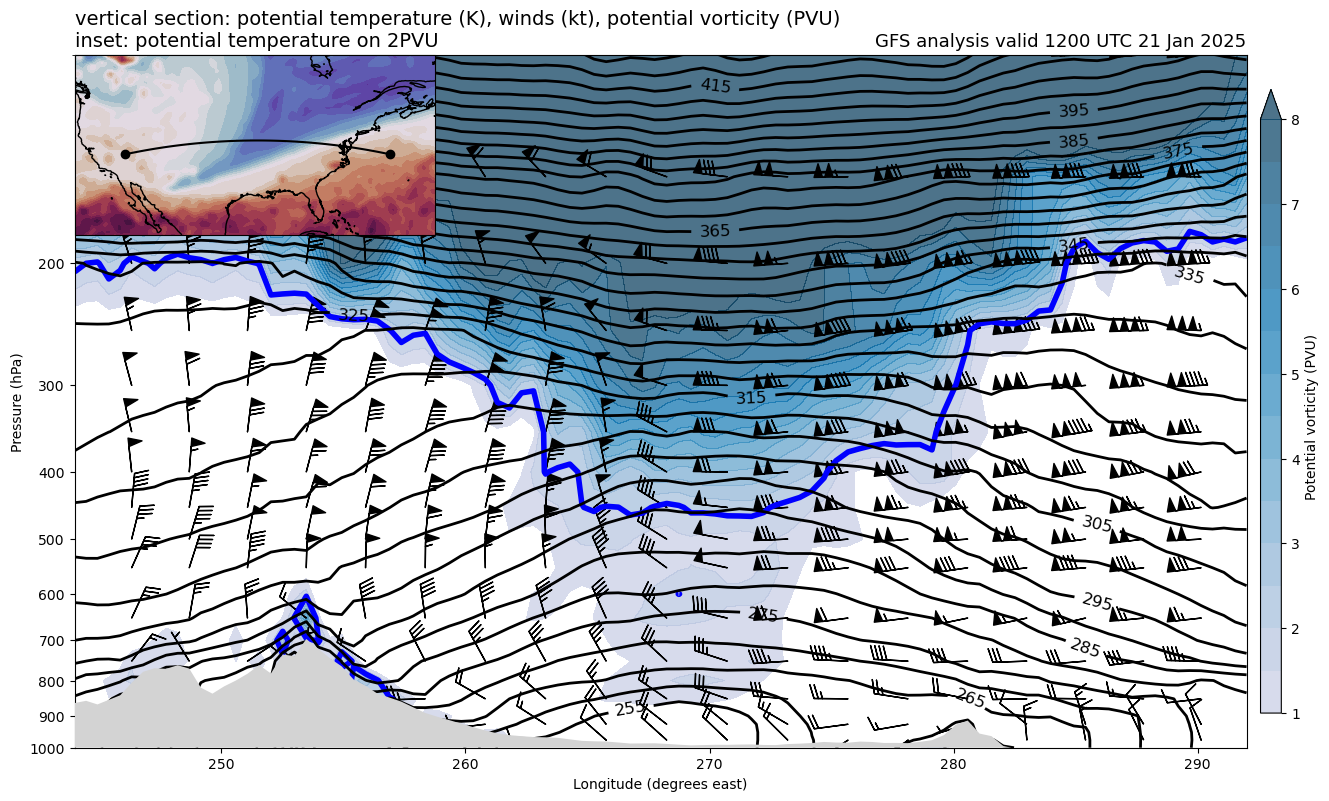

In [69]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(18., 9.))
ax = plt.axes()

## adjust colormap to remove lowest (very light) colors
orig_cmap = plt.cm.PuBu
colors = orig_cmap(np.linspace(0.25, 1, 10)) ### start 25% of the way through the cmap
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

# Plot PV using contourf
pv_contour = ax.contourf(cross['lon'], cross['isobaric'], cross['Potential_vorticity']*1e6,
                         levels=np.arange(1, 8.5, 0.5), 
                         cmap=cmap, extend='max', alpha=0.7)
pv_colorbar = fig.colorbar(pv_contour,pad=0.01, aspect=30, shrink=0.9)

### also highlight the 2PVU contour
contour_2pvu = ax.contour(cross['lon'], cross['isobaric'], cross['Potential_vorticity']*1e6,
                         levels=np.arange(2,3,1), 
                          colors='blue', linewidths=4)

# Plot potential temperature using contour, with some custom labeling
theta_contour = ax.contour(cross['lon'], cross['isobaric'], cross['Potential_temperature'],
                           levels=np.arange(250, 450, 5), colors='k', linewidths=2)
theta_contour.clabel(theta_contour.levels[1::2], fontsize=12, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

## plot terrain height
ax.fill_between(cross['lon'], cross['elevation'], 1000,
                where=cross['elevation'].values <= 1000., facecolor='lightgrey',
                interpolate=True, zorder=10)

# Plot winds using the axes interface directly, with some custom indexing to make the barbs
# less crowded
#wind_slc_vert = list(range(0, 19, 2)) + list(range(19, 29))
#wind_slc_vert = list(range(0,41,1))
wind_slc_vert = list(range(0,29,1)) + list(range(29,41,2))
#wind_slc_vert = list(range(0,31,1))
wind_slc_horz = slice(5, 100, 5)
ax.barbs(cross['lon'][wind_slc_horz], cross['isobaric'][wind_slc_vert],
         cross['t_wind'][wind_slc_vert, wind_slc_horz],
         cross['n_wind'][wind_slc_vert, wind_slc_horz], color='k')

# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 100, -100))
#ax.set_ylim(cross['isobaric'].max(), cross['isobaric'].min())
ax.set_ylim(1000,100)
ax.set_yticks(np.arange(1000, 100, -100))

# Define the CRS and inset axes
data_crs = data_subset['Geopotential_height_isobaric'].metpy.cartopy_crs
ax_inset = fig.add_axes([0.125, 0.68, 0.2, 0.2], projection=data_crs)
ax_inset.set_extent([-125,-60,22.5,55], data_crs)

# Plot PV at 250 hPa using xarray's contour wrapper
#ax_inset.contourf(data_subset['lon'], data_subset['lat'], data_subset['Potential_vorticity'].sel(isobaric=25000.)*1e6,
#                 levels=np.arange(3,15,2), cmap='inferno', alpha=0.6)

## Plot DT theta
clevs_dt = np.arange(260,400,5)
ax_inset.contourf(dt_subset.lon, dt_subset.lat, dt_theta, clevs_dt, extend='both', cmap=plt.cm.twilight_shifted)

# Plot the path of the cross section
endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(cross['lon'], cross['lat'], c='k', zorder=2, transform=data_crs)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
ax_inset.set_title('')
#ax.set_title(f'GFS analysis Cross-Section \u2013 {start} to {end} \u2013 '
#             f'Valid: {cross["time"].dt.strftime("%Y-%m-%d %H:%MZ").item()}\n'
#             'Potential Temperature (K), Tangential/Normal Winds (knots), Potential vorticity '
#             '(PVU)\nInset: Cross-Section Path and potential temperature on 2PVU')
ax.set_title("vertical section: potential temperature (K), winds (kt), potential vorticity (PVU)\ninset: potential temperature on 2PVU", 
             loc='left', fontsize=14)
ax.set_title("GFS analysis valid "+vtime.strftime("%H%M UTC %d %b %Y"), 
             loc='right', fontsize=13)

ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Longitude (degrees east)')
pv_colorbar.set_label('Potential vorticity (PVU)')

fig.savefig("xsec_pv_"+vtime.strftime('%Y%m%d')+"_"+vtime.strftime('%H%M')+".png",
           dpi=255, bbox_inches='tight', transparent=False, facecolor='white')

plt.show()

plt.close('all')


Repeat for one with isotachs added
----------

/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_32692/1811375206.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(1000, 100, -100))


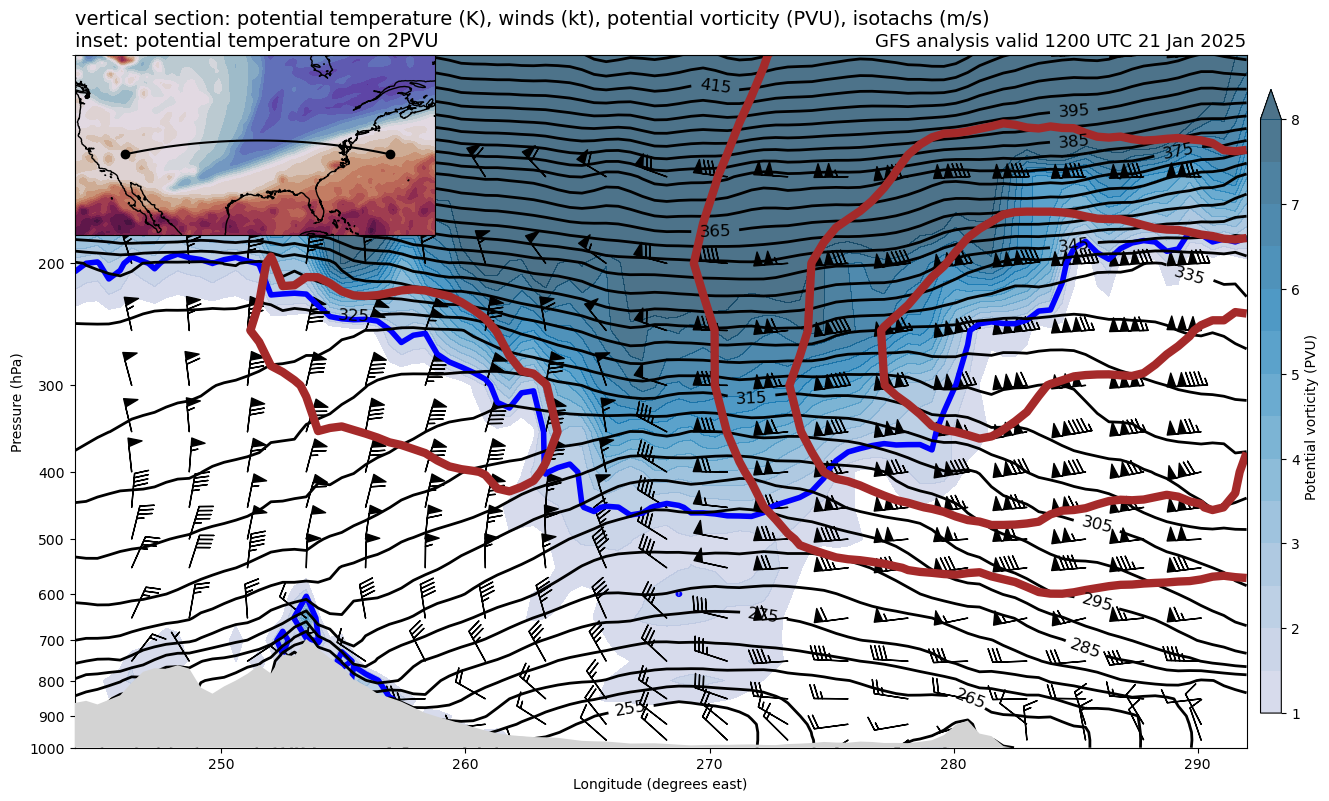

In [70]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(18., 9.))
ax = plt.axes()

# Plot PV using contourf
pv_contour = ax.contourf(cross['lon'], cross['isobaric'], cross['Potential_vorticity']*1e6,
                         levels=np.arange(1, 8.5, 0.5), 
                         cmap=cmap, extend='max', alpha=0.7)
pv_colorbar = fig.colorbar(pv_contour,pad=0.01, aspect=30, shrink=0.9)

### also highlight the 2PVU contour
contour_2pvu = ax.contour(cross['lon'], cross['isobaric'], cross['Potential_vorticity']*1e6,
                         levels=np.arange(2,3,1), 
                          colors='blue', linewidths=4)

# Plot potential temperature using contour, with some custom labeling
theta_contour = ax.contour(cross['lon'], cross['isobaric'], cross['Potential_temperature'],
                           levels=np.arange(250, 450, 5), colors='k', linewidths=2)
theta_contour.clabel(theta_contour.levels[1::2], fontsize=12, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

## add isotachs
contour_wspd = ax.contour(cross['lon'], cross['isobaric'], cross['wind_speed'],
                         levels=np.arange(40,120,20), 
                          colors='brown', linewidths=6)

## plot terrain height
ax.fill_between(cross['lon'], cross['elevation'], 1000,
                where=cross['elevation'].values <= 1000., facecolor='lightgrey',
                interpolate=True, zorder=10)

# Plot winds using the axes interface directly, with some custom indexing to make the barbs
# less crowded
#wind_slc_vert = list(range(0, 19, 2)) + list(range(19, 29))
#wind_slc_vert = list(range(0,41,1))
wind_slc_vert = list(range(0,29,1)) + list(range(29,41,2))
#wind_slc_vert = list(range(0,31,1))
wind_slc_horz = slice(5, 100, 5)
ax.barbs(cross['lon'][wind_slc_horz], cross['isobaric'][wind_slc_vert],
         cross['t_wind'][wind_slc_vert, wind_slc_horz],
         cross['n_wind'][wind_slc_vert, wind_slc_horz], color='k')

# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 100, -100))
#ax.set_ylim(cross['isobaric'].max(), cross['isobaric'].min())
ax.set_ylim(1000,100)
ax.set_yticks(np.arange(1000, 100, -100))

# Define the CRS and inset axes
data_crs = data_subset['Geopotential_height_isobaric'].metpy.cartopy_crs
ax_inset = fig.add_axes([0.125, 0.68, 0.2, 0.2], projection=data_crs)
ax_inset.set_extent([-125,-60,22.5,55], data_crs)

# Plot PV at 250 hPa using xarray's contour wrapper
#ax_inset.contourf(data_subset['lon'], data_subset['lat'], data_subset['Potential_vorticity'].sel(isobaric=25000.)*1e6,
#                 levels=np.arange(3,15,2), cmap='inferno', alpha=0.6)
## Plot DT theta
clevs_dt = np.arange(260,400,5)
ax_inset.contourf(dt_subset.lon, dt_subset.lat, dt_theta, clevs_dt, extend='both', cmap=plt.cm.twilight_shifted)

# Plot the path of the cross section
endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(cross['lon'], cross['lat'], c='k', zorder=2, transform=data_crs)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
ax_inset.set_title('')
#ax.set_title(f'GFS analysis Cross-Section \u2013 {start} to {end} \u2013 '
#             f'Valid: {cross["time"].dt.strftime("%Y-%m-%d %H:%MZ").item()}\n'
#             'Potential Temperature (K), Tangential/Normal Winds (knots), Potential vorticity '
#             '(PVU), Wind Speed (m/s)\nInset: Cross-Section Path and potential temperature on 2PVU')
ax.set_title("vertical section: potential temperature (K), winds (kt), potential vorticity (PVU), isotachs (m/s)\ninset: potential temperature on 2PVU", 
             loc='left', fontsize=14)
ax.set_title("GFS analysis valid "+vtime.strftime("%H%M UTC %d %b %Y"), 
             loc='right', fontsize=13)

ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Longitude (degrees east)')
pv_colorbar.set_label('Potential vorticity (PVU)')

fig.savefig("xsec_pv_wspd_"+vtime.strftime('%Y%m%d')+"_"+vtime.strftime('%H%M')+".png",
           dpi=255, bbox_inches='tight', transparent=False, facecolor='white')

plt.show()

plt.close('all')


And just a blank one
----------

/var/folders/75/5p7qdm_177xcdzfy73vdj1rh0001bx/T/ipykernel_32692/1434844293.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(1000, 100, -100))


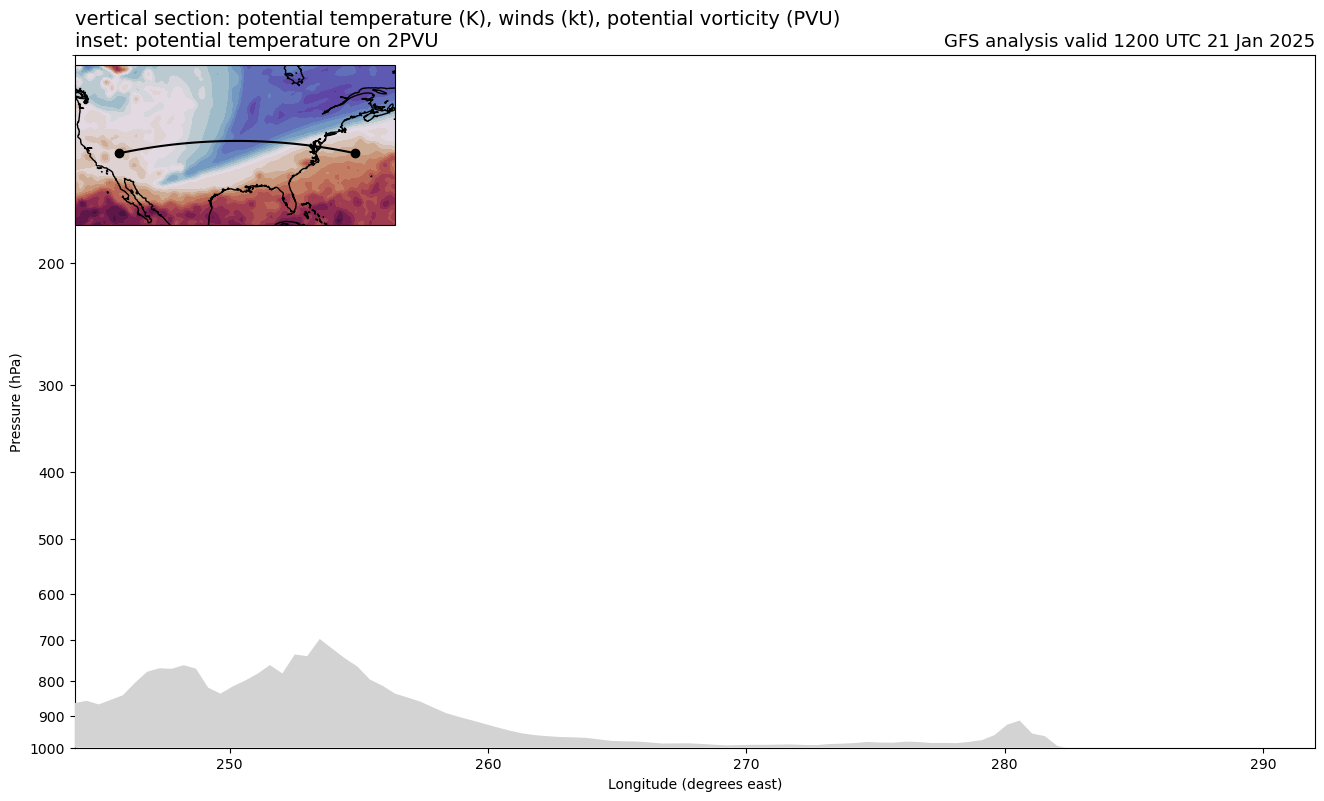

In [71]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

# Plot undefined potential temperature contours, because for some reason it helps the terrain fill look right
theta_contour = ax.contour(cross['lon'], cross['isobaric'], cross['Potential_temperature'],
                           levels=np.arange(0,100,10), colors='k', linewidths=2)

## plot terrain height
ax.fill_between(cross['lon'], cross['elevation'], 1000,
                where=cross['elevation'].values <= 1000., facecolor='lightgrey',
                interpolate=True, zorder=10)

# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 100, -100))
#ax.set_ylim(cross['isobaric'].max(), cross['isobaric'].min())
ax.set_ylim(1000,100)
ax.set_yticks(np.arange(1000, 100, -100))

# Define the CRS and inset axes
data_crs = data_subset['Geopotential_height_isobaric'].metpy.cartopy_crs
ax_inset = fig.add_axes([0.125, 0.68, 0.2, 0.2], projection=data_crs)
ax_inset.set_extent([-125,-60,22.5,55], data_crs)

# Plot PV at 250 hPa using xarray's contour wrapper
ax_inset.contourf(data_subset['lon'], data_subset['lat'], data_subset['Potential_vorticity'].sel(isobaric=25000.)*1e6,
                 levels=np.arange(3,15,2), cmap='inferno', alpha=0.6)
## Plot DT theta
clevs_dt = np.arange(260,400,5)
ax_inset.contourf(dt_subset.lon, dt_subset.lat, dt_theta, clevs_dt, cmap=plt.cm.twilight_shifted)

# Plot the path of the cross section
endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(cross['lon'], cross['lat'], c='k', zorder=2, transform=data_crs)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
ax_inset.set_title('')
#ax.set_title(f'GFS analysis Cross-Section \u2013 {start} to {end} \u2013 '
#             f'Valid: {cross["time"].dt.strftime("%Y-%m-%d %H:%MZ").item()}\n'
#             'Potential Temperature (K), Tangential/Normal Winds (knots), Potential vorticity '
#             '(PVU)\nInset: Cross-Section Path and potential temperature on 2PVU')
ax.set_title("vertical section: potential temperature (K), winds (kt), potential vorticity (PVU)\ninset: potential temperature on 2PVU", 
             loc='left', fontsize=14)
ax.set_title("GFS analysis valid "+vtime.strftime("%H%M UTC %d %b %Y"), 
             loc='right', fontsize=13)

ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Longitude (degrees east)')
pv_colorbar.set_label('Potential vorticity (PVU)')

fig.savefig("xsec_pv_blank_"+vtime.strftime('%Y%m%d')+"_"+vtime.strftime('%H%M')+".png",
           dpi=255, bbox_inches='tight', transparent=False, facecolor='white')

plt.show()

plt.close('all')


We also need a DT map to show
-----------

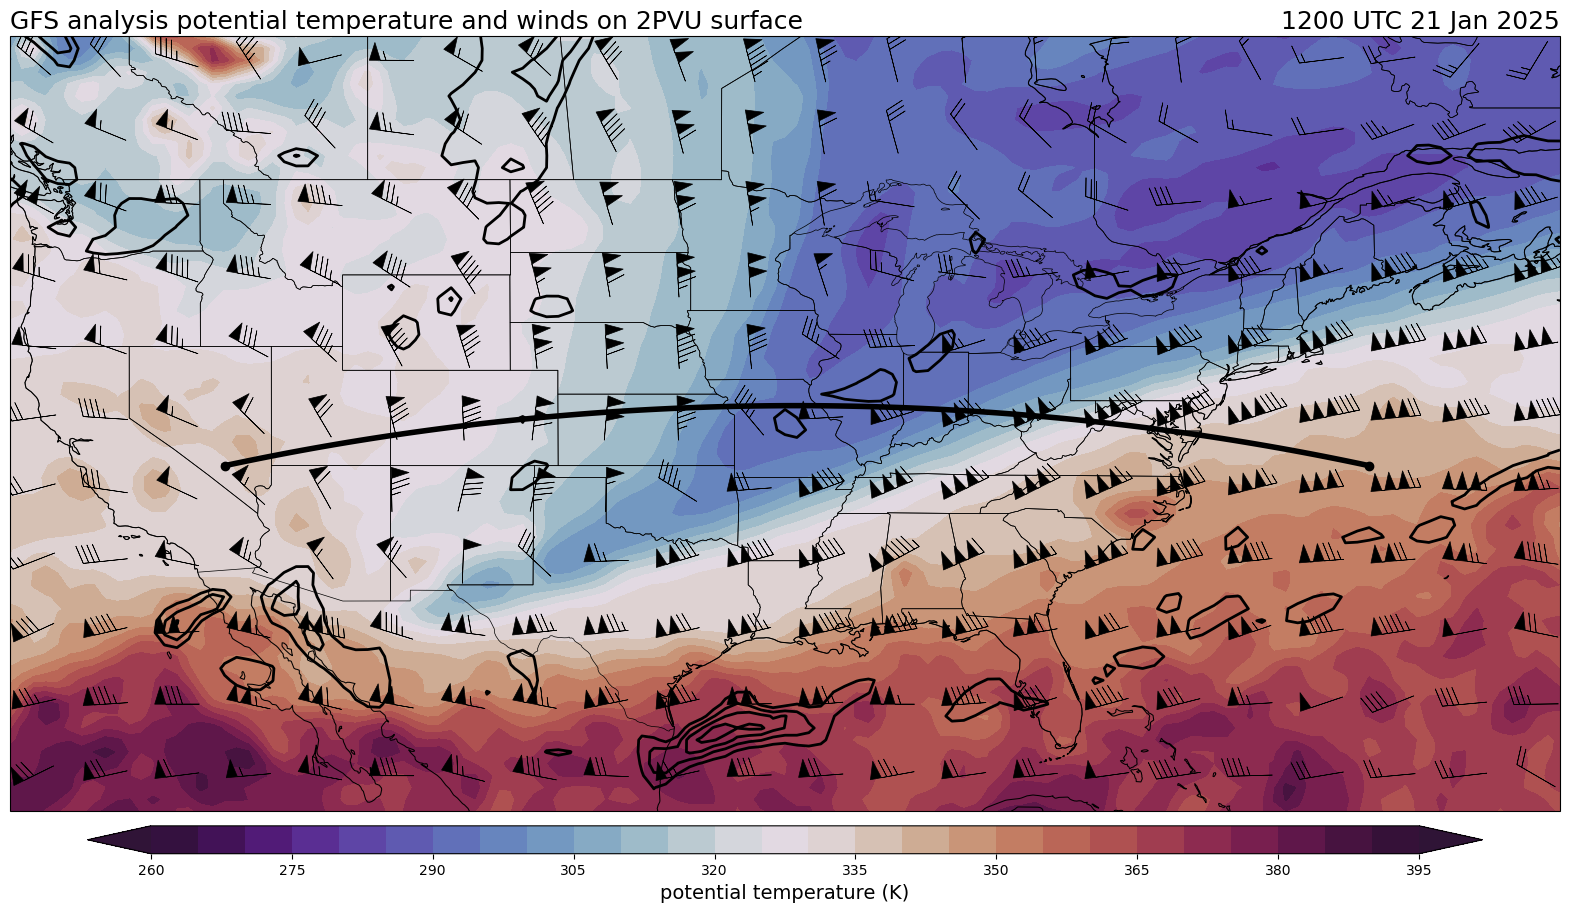

In [72]:
# Set Projection of Data
#datacrs = ccrs.PlateCarree()

# Set Projection of Plot
#plotcrs = ccrs.LambertConformal(central_latitude=45, central_longitude=-100)
data_crs = data_subset['Geopotential_height_isobaric'].metpy.cartopy_crs

fig = plt.figure(1, figsize=(20,16))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)
ax = plt.subplot(gs[0], projection=data_crs)

# Plot Titles
plt.title(r'GFS analysis potential temperature and winds on 2PVU surface',
          loc='left', fontsize=18)
plt.title(vtime.strftime("%H%M UTC %d %b %Y"), loc='right', fontsize=18)

# Plot Background
#ax.set_extent([217.5, 290., 18., 66.])
#ax.set_extent([227.5, 290., 20., 56.])
ax.set_extent([-125,-60,22.5,55], data_crs)
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=.5)

# Plot Colorfill DT theta
clevs_dt = np.arange(260,400,5)
cf = ax.contourf(dt_subset.lon, dt_subset.lat, dt_theta, clevs_dt, cmap=plt.cm.twilight_shifted,
                 extend='both',
                 transform=data_crs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0.01, aspect=50, shrink=0.9)
cb.set_label('potential temperature (K)', fontsize=14)

# Plot vort contours
clev850 = np.arange(5,35,5)
cs = ax.contour(data_subset.lon, data_subset.lat, relvor_850*1e5, clev850, colors='black', linewidths=2,
                linestyles='solid', transform=ccrs.PlateCarree())

# Plot Wind Barbs
# Transform Vectors and plot wind barbs.
wind_slice = slice(None, None, 6)
ax.barbs(dt_subset.lon[wind_slice], dt_subset.lat[wind_slice], 
         dt_subset['u-component_of_wind_potential_vorticity_surface'][wind_slice,wind_slice].metpy.convert_units('kt'),
         dt_subset['v-component_of_wind_potential_vorticity_surface'][wind_slice,wind_slice].metpy.convert_units('kt'),
         length=8, linewidth=0.5,pivot='middle', transform=ccrs.PlateCarree())
                
# Plot the path of the cross section
endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax.plot(cross['lon'], cross['lat'], c='k', zorder=2, 
        linewidth=4, transform=data_crs)

outfile="dt_theta_gfs_"+vtime.strftime('%Y%m%d')+"_"+vtime.strftime('%H%M')+".png"
fig.savefig(outfile, dpi=255, bbox_inches='tight', transparent=False, facecolor='white')
#os.system("mv "+outfile+" "+case_date+"/.")
plt.show()

plt.close('all')